,id,pub_date,headline_senti,summary_senti,headline_summary_senti,lead_paragraph_senti,keyword_in_headline,keyword_in_summary,keyword_org_rank_alt,section_name,type_of_material,print_page,word_count,trade_date,price,percent_change
0,54a4a6d338f0d83a07dc4ed6,2015-01-01T00:00:00Z,0.0,-0.7003,-0.7003,0.2023,0,1,1.0,Opinion,Editorial,18,506.0,2015-01-02,526.114746,-0.422092


,headline_senti,summary_senti,headline_summary_senti,lead_paragraph_senti,keyword_in_headline,keyword_in_summary,keyword_org_rank_alt,word_count,price,percent_change
count,6624.000000,6624.000000,6624.000000,6624.000000,6624.000000,6624.000000,6624.000000,6616.000000,6624.000000,6615.000000
mean,0.018256,0.147930,0.156459,0.147765,0.495773,0.780344,0.302502,552.447098,301.764384,0.103071
std,0.240364,0.413486,0.459212,0.417696,0.500020,0.414045,0.385816,507.612659,118.754949,2.108167
min,-0.891000,-0.985000,-0.985000,-0.999600,0.000000,0.000000,0.000000,0.000000,49.676899,-11.563501
25%,0.000000,0.000000,-0.051600,0.000000,0.000000,1.000000,0.000000,222.000000,229.630230,-0.893498
50%,0.000000,0.025800,0.128000,0.000000,0.000000,1.000000,0.000000,440.000000,279.546814,0.088970
75%,0.000000,0.475400,0.526700,0.440400,1.000000,1.000000,0.500000,789.250000,328.925659,1.114258
max,0.868900,0.995200,0.995200,0.999600,1.000000,1.000000,1.000000,17686.000000,669.200012,18.102495


683.0:2116.0
1745.0:6624.0


,Date,Open,Change,HasNews
2793,2015-09-23,622.049988,-0.789476,0
2794,2015-09-24,616.640015,-0.869701,1
2795,2015-09-25,629.770020,2.129282,0
2796,2015-09-28,610.340027,-3.085252,1
2797,2015-09-29,597.280029,-2.139791,1


(-11.577297457007496, 18.116291751368273)

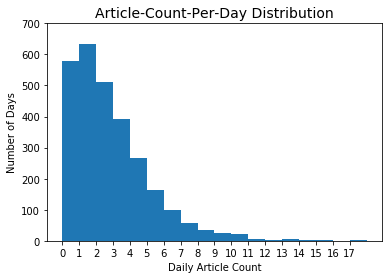

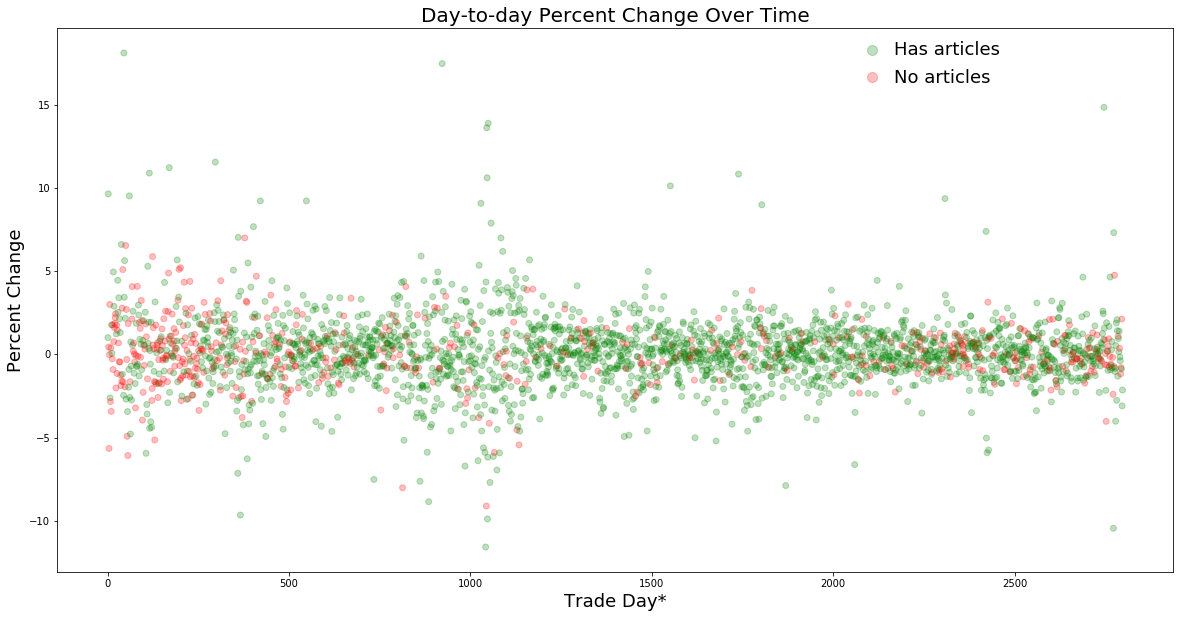

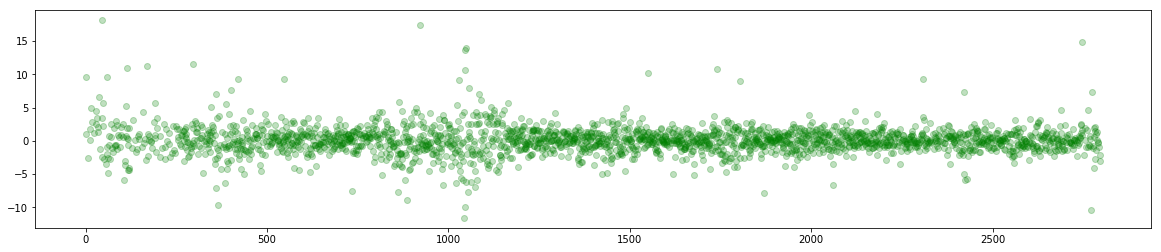

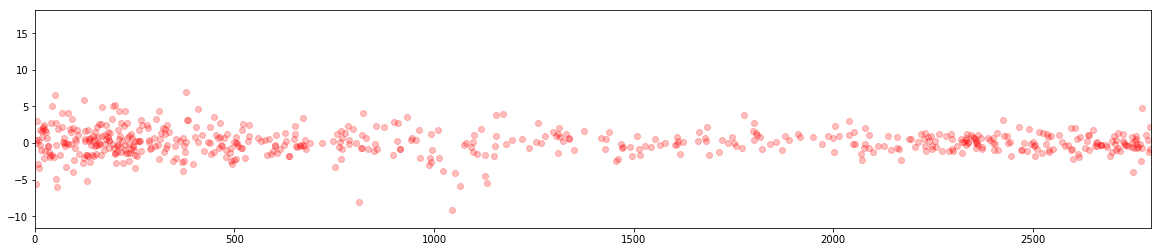

In [4]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from collections import Counter
from dateutil.parser import parse
from collections import OrderedDict
from datetime import datetime, date, timedelta
from IPython.display import display # Allows the use of display() for DataFrames
from scipy import stats

# Pretty display for notebooks
%matplotlib inline

# Load the dataset
data = pd.read_csv("../data/ny_times/google/news_features.csv")

# Success - Display the first record
display(data.head(n=1))
display(data.describe())

# article count by trade date
article_count = Counter(data['trade_date'])

# find trade dates with no articles
trade_data = pd.read_csv("../data/GOOG.csv")
trade_data = trade_data[['Date', 'Open']]
valid_range = [i for i in trade_data.index if parse(trade_data.Date[i]).date()==date(2015,9,30)\
                 or parse(trade_data.Date[i]).date()==date(2004,8,19)] # data is in chronological order, so just store endpoints
trade_data = trade_data[valid_range[0]:valid_range[1]]
trade_dates_0 = [d for d in trade_data.Date if d not in article_count]

# update counter to include trade dates with no articles
for d in trade_dates_0:
    article_count[d]=0

# print(article_count)

# trade dates with more than 10 articles
# date = [i[0] for i in article_count.iteritems() if i[1]>10 ]
# print(date)


# -----------------------------------------------------------------------------------------
# plot distribution of article-count-per-day
# calculate basic related stats

# plot histogram: frequency of article count
fig, ax = plt.subplots()
article_freq = article_count.values()
# print(range(min(article_freq), max(article_freq) + 1, 1))
values, bins, _= ax.hist(article_freq, bins=range(min(article_freq), max(article_freq) + 2, 1))

ax.set_title("Article-Count-Per-Day Distribution", fontsize = 14)
ax.set_xlabel("Daily Article Count")
ax.set_ylabel("Number of Days")
ax.set_ylim((0, 700))
ax.set_xticks(range(min(article_freq), max(article_freq) + 1, 1))
ax.set_xticklabels(range(min(article_freq), max(article_freq) + 1, 1))

# number of trade days with 3 articles or less
days_3rless = sum(values[0:4])

# number of trade days with more than 3 articles
days_4rmore = sum(values[4:])

print("{0}:{1}").format(days_4rmore, days_3rless)

# approx. fraction of articles comprising the top 3 articles of each day
articles_total = sum(np.multiply(bins[:-1],values))

# number of articles to be filtered out if only top 3 articles of each day is used
articles_remove = sum(np.multiply(bins[4:-1],values[4:])) - 3*sum(values[4:])

# fraction of articles to be removed
print("{0}:{1}").format(articles_remove, articles_total)


# --------------------------------------------------------------------------
# plot day-to-day percent changes for trade days with no associated articles
# vs. those that do

# add daily percent change column to dataframe
percent_change = [(trade_data.Open[i] - trade_data.Open[i-1])/trade_data.Open[i-1]*100\
                  if i>0 else None for i in range(0, trade_data.Open.size)]
trade_data['Change']= pd.Series(percent_change, index=trade_data.index)

# print(percent_change)

# add column that tags whether the trade day has associated articles or not
tags = [0 if d in trade_dates_0 else 1 for d in trade_data.Date]
trade_data['HasNews'] = pd.Series(tags, index=trade_data.index)
# print(tags)
display(trade_data.tail(n=5))

fig1, ax1 = plt.subplots(figsize=(20,10))
colors = ['red' if c==0 else 'green' for c in trade_data.HasNews]
ax1.scatter(trade_data.index, trade_data.Change, c=colors, alpha=0.25)
ax1.set_title("Day-to-day Percent Change Over Time", fontsize = 20)
ax1.set_xlabel("Trade Day*", fontsize=18) # Where '0' corresponds to the first trade day in the data series
ax1.set_ylabel("Percent Change",fontsize=18)
ax1.text(.75,.95,"Has articles",transform=ax1.transAxes,fontsize=18)
ax1.text(.75,.9,"No articles",transform=ax1.transAxes,fontsize=18)
ax1.plot(.73, .96, 'ko', transform=ax1.transAxes, fillstyle = 'full', color='green',alpha=0.25, markersize = 10.0) 
ax1.plot(.73, .91, 'ko', transform=ax1.transAxes, fillstyle = 'full', color='red',alpha=0.25, markersize = 10.0) 

# plot percent change for trade days with articles
trade_data_hasNews = trade_data[trade_data.HasNews==1]
fig3, ax3 = plt.subplots(figsize=(20,4))
ax3.scatter(trade_data_hasNews.index, trade_data_hasNews.Change, c='green', alpha=0.25)

# stats & plot percent change for trade days with no articles
trade_data_noNews = trade_data[trade_data.HasNews==0]
fig2, ax2 = plt.subplots(figsize=(20,4))
ax2.scatter(trade_data_noNews.index, trade_data_noNews.Change, c='red', alpha=0.25)
ax2.set_xlim((ax3.dataLim.x0,ax3.dataLim.x1))
ax2.set_ylim((ax3.dataLim.y0,ax3.dataLim.y1))

# Comments on scatterplot:
# day-to-day changes >= 7% mostly corresponds to 'has-news' days. 
# Fluctuations on 'no-news' days can correspond to: (1) events not capture by nyt 
# (2) carry-over effects of news from previous days
# *Note the visual biases inherent in this plot as the ratio of no-news to has-news is ~6:28 -> ~1:5 
